#### Kaggle competition

Label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond


#### What the data looks like ? 
Train-jpg: 40K+ satelite photos <br>
train_v2: (image_name, tags) Unique tags 449 <br>
So this is a multilabel image classification problem

#### Challenge
Unlike dog and cat image recognition, the image set are very similar in colors


In [11]:
from __future__ import division
from scipy.integrate import cumtrapz
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob, os
import cv2

In [10]:
# kaggle_path = '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/train-jpg/'
kaggle_path = '/Users/mumuxi/.kaggle/competitions/planet-understanding-the-amazon-from-space/train-jpg/'
labels = pd.read_csv('train_v2.csv')
print ('Number of unique tags',len(labels['tags'].unique()))
labels.head(5)

Number of unique tags 449


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


TypeError: Image data cannot be converted to float

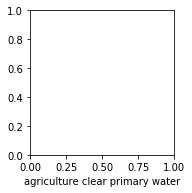

In [33]:
def example_photos(rows,columns):
    fig=plt.figure(figsize=(15, 15))
    for i in range(1, columns*rows +1):
        path = kaggle_path+f'train_{i}.jpg'
        img = cv2.imread(path)
        ax = fig.add_subplot(rows, columns, i)
        ax.set_xlabel(labels.tags[i])
        plt.imshow(img)
example_photos(rows=4,columns=5)

#### Evaluation - F2 SCORE
F2 is used to evaluate how good the model is and has a formula given below

$F_{2} = (1+β^{2})\frac{pr}{β^{2}p+r}$


,where *p* is precision, *r* is recall and β=2 

In [8]:
def F2score(p,r,beta=2):
    return (1+beta**2)*p*r/(beta**2*p+r)

### 1. Dehaze images
Source: [Single Image Haze Removal Using Dark Channel Prior](https://www.robots.ox.ac.uk/~vgg/rg/papers/hazeremoval.pdf)

The following formula is widely used to describe the formation of a haze image

$I(x) = J(x)t(x) + A(1-t(x))$

where *I* is the observed intensity, *J* represents the original haze-free image to be recovered, *A* is the global atmospheric light, and *t* is an exponential decay distribution .

The aim is to recover *J* from *I*. We can achieve that by tuning *t*, as *t* has a formula of

$t(x) = 1- w\times min[min(\frac{I_{c}(y)}{A^{c}})]$
,where *w* is weight coefficient, *c* is the dark channel color (darkest channel of RGB channel)
```python
find_intensity_of_atmospheric_light # get Atomospheric light
```

In [32]:
"""Single image dehazing."""
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray):
    # pick top 0.1% brightest pixels in the dark channel ~ most hazeopaque
    top_num = int(img.shape[0] * img.shape[1] * 0.001)
    toplist = [Channel_value()] * top_num 
    dark_channel = find_dark_channel(img)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            val = img.item(y, x, dark_channel)
            intensity = gray.item(y, x)
            for t in toplist:  # create 65 different channels 
                if t.val < val or (t.val == val and t.intensity < intensity):
    ##       update channel with bigger val and greater intensity
                    t.val = val
                    t.intensity = intensity
                    break
    max_channel = Channel_value()
    for t in toplist:
        if t.intensity > max_channel.intensity:
            max_channel = t
    return max_channel.intensity

def find_dark_channel(img): #get min intensity pixel's color channel
    return np.unravel_index(np.argmin(img), img.shape)[2]

def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

def dehaze(img, light_intensity, windowSize, t0, w):
    size = (img.shape[0], img.shape[1])
    outimg = np.zeros(img.shape, img.dtype)
    for y in range(size[0]):
        for x in range(size[1]):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), size[1])
            y_high = min(y+(windowSize//2), size[0])
            sliceimg = img[y_low:y_high, x_low:x_high]
            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)
            outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))
    return outimg


def dehaze_image(path,w = 0.95, t0 = 0.55):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
    light_intensity = find_intensity_of_atmospheric_light(img, gray)
#     print ('light intensity',light_intensity)
    outimg = dehaze(img, light_intensity, 20, t0, w)
    return outimg

def example_photo_no(path):
    img = cv2.imread(path)
    plt.imshow(img)
    
def intensity_plot(path):
    img = cv2.imread(path)
    color = ('b','g','r')
    histr = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(histr)
## %%%%%%%%      GRB PLOT   %%%%%%%%
#     for i,col in enumerate(color):
#         histr = cv2.calcHist([img],[i],None,[256],[0,256])
#         plt.plot(histr,color = col)
#         plt.xlim([0,256])
# ##  %%%%%%%     CDF plot    %%%%%%%%
#     values, bins = np.histogram(img.ravel(),256,[0,256],normed=True)
#     cum = np.cumsum(values)
#     plt.plot(bins[:-1],cum)

def compare_photos(image_id):
    kaggle_path = '/Users/mumuxi/.kaggle/competitions/planet/train-jpg/'
    path = kaggle_path+f'train_{image_id}.jpg'
    fig=plt.figure(figsize=(5, 8))
    ax1 = fig.add_subplot(211)
    dehaze_image(path)
    fig.add_subplot(212,sharex=ax1)
    example_photo_no(path)
    plt.show()

light intensity 95


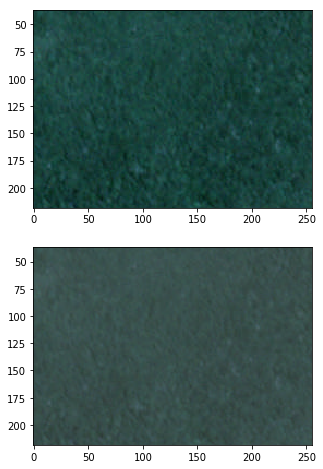

In [31]:
compare_photos(154)

### 1 Tags EDA
- Most tags contains primary
- Clear has strong negative correlations with cloudy, haze, partly 

In [4]:
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.image import ImageDataGenerator
from sklearn import datasets, model_selection, preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

/Users/mumuxi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
texts = labels.tags.tolist()
tokenizer = Tokenizer(filters='"#()*+,-./:;<=>?@[\]^`{|}~')
tokenizer.fit_on_texts(texts)

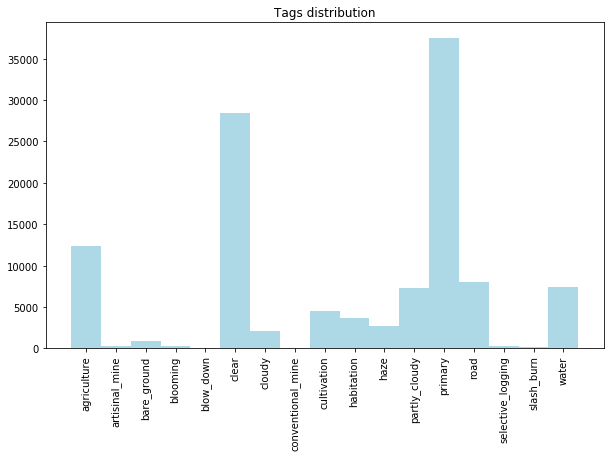

In [6]:
def plot_tags(tags):
    fig=plt.figure(figsize=(10, 6))
    plt.bar(tags.keys(), tags.values(), 1, color='lightblue')
    plt.xticks(rotation=90)
    plt.title('Tags distribution')
plot_tags(tokenizer.word_docs)

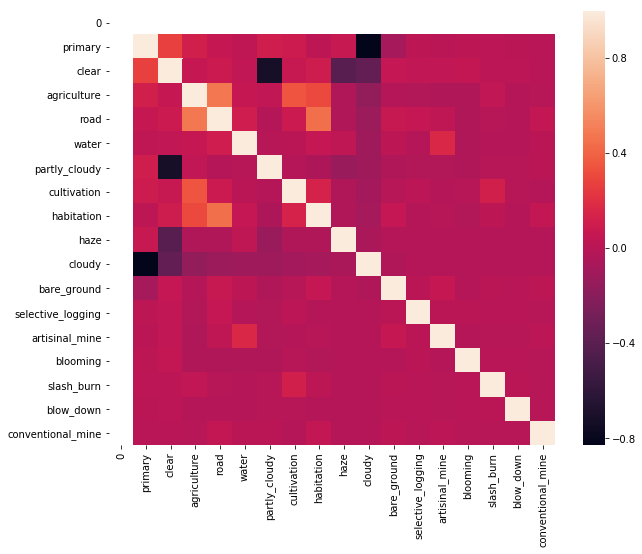

In [7]:
def count_vectorizer(M):
    df = pd.DataFrame(data=M,columns=['0']+list(tokenizer.word_index.keys()))
    corr = df.corr()
    fig=plt.figure(figsize=(10, 8))
    sns.heatmap(corr)
    df['image_name'] = labels.image_name
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[1:-1]
    df = df[cols]
    return df
df_t = count_vectorizer(tokenizer.texts_to_matrix(texts, mode='count'))

In [57]:
df_t.loc[df_t['haze']==1,'image_name'].index

Int64Index([    0,     5,     7,    43,    60,   104,   132,   133,   136,
              152,
            ...
            40342, 40351, 40359, 40373, 40378, 40379, 40424, 40440, 40463,
            40469],
           dtype='int64', length=2697)

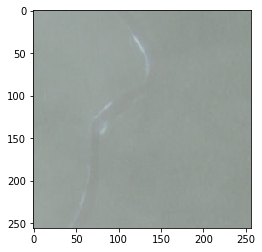

In [54]:
example_photo_no(5)

### 1 Neural Network vanilla model
- Importing the Keras libraries and packages
- Sequential:<br> initialise model as a sequential network. There are two basic ways of initialising a neural network, either by a sequence of layers or as a graph

#### 1.1 Model Work Flow
1. **Conv2D** 
    - Images => 2 D arrays
    - Videos => Convolution 3-D 
    
    
2. **MaxPooling2D**:<br> The primary aim of a pooling operation is to reduce the size of the images. Different types of pooling operations like Min Pooling, Mean Pooling, etc. Here in MaxPooling we need the maximum value pixel from the respective region of interest.


3. **Flatten**:<br> Flattening is the process of converting all the resultant 2 dimensional arrays into a continuous vector.


4. **Dense** 
    - units: no nodes in the hidden layer
5. **compile**
    - Optimizer:  stochastic gradient descent algorithm
    - Loss: loss function
    - Metrics: performance metric

In [47]:
def load_data(N,start=0):
    img_L = []
    for i in range(start,N):
        img = cv2.imread(kaggle_path+f'train_{i}.jpg')
        img_L.append(img)
    return np.array(img_L),df_t.iloc[start:N,1::]
X_train,y_train = load_data(1000)
X_test,y_test = load_data(1500,start=1000)

In [48]:
no_features = 17
print (X_test.shape,y_test.shape)

(500, 256, 256, 3) (500, 17)


32 filters of size 12x12<br>
input image size 256 x 256, 3 for RGB

In [49]:
classifier = Sequential()
classifier.add(Conv2D(32, kernel_size=(12,12), 
               activation = 'relu',
               input_shape = (256, 256, 3), 
               ))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = no_features, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

In [50]:
classifier.fit(dX_train, y_train, epochs=2, batch_size=200)

Epoch 1/2
1000/1000 [==============================] - 769s 769ms/step - loss: 3.5541 - acc: 0.7512
Epoch 2/2
1000/1000 [==============================] - 720s 720ms/step - loss: 3.0178 - acc: 0.8111


#### 1.2 Pre-processing image
The directory name is taken as the label of all the images present in it.

In [52]:
score = classifier.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.038426975250244
Test accuracy: 0.8098823533058167
